<a href="https://colab.research.google.com/github/AisIzmailova/AisIzmailova_Practice_Notebooks/blob/master/NLP_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Natural Language Processing

NLP has the goal of deriving information out of natural language. A common term for NLP is sequence to sequence problem.

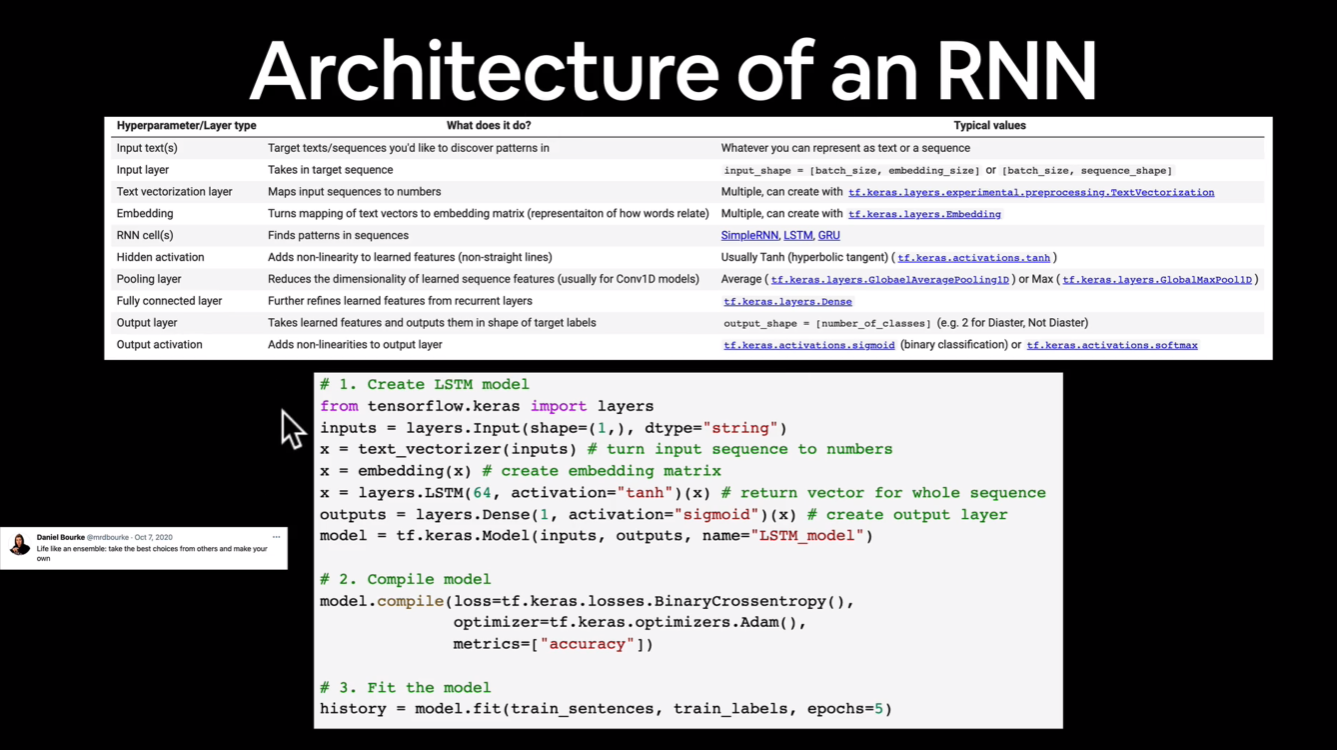

##1.Get data

We will be using Kaggle's introduction to NLP dataset (text samples of tweets labelled as disaster/not disaster).

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os
import pathlib
import numpy as np
import random
import datetime

In [2]:
from helper_functions import create_tensorboard_callback, create_model_checkpoint_callback, unzip_file, compare_histories

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2023-12-31 05:31:37--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.207, 142.251.111.207, 142.251.16.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2023-12-31 05:31:37 (83.3 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [4]:
unzip_file("nlp_getting_started.zip")

##2.Visualize text dataset

To visualize our text samples, we first need to read them in, one way to do so would be to use pandas.

In [5]:
train_data = pd.read_csv("train.csv")
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_data = pd.read_csv("test.csv")

In [7]:
#Shuffle training dataframe
train_data_shuffled = train_data.sample(frac=1, random_state=42)

In [8]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
#How many examples of each class
train_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Read: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [10]:
len(train_data), len(test_data)

(7613, 3263)

In [11]:
#Let's visualize 10 random text samples
random_index=random.randint(0, len(train_data)-5)
for row in train_data_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  #return a tuple of text and target
  _, text, target = row
  print(f"Target: {target}", "(real_disaster)" if target>0 else "(not real disaster)")
  print(f"Text: {text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text: @emaaalay thank you. ?? now I don't have a city wide curfew. ????

---

Target: 0 (not real disaster)
Text: To fight bioterrorism sir.

---

Target: 0 (not real disaster)
Text: YOUR PHONE IS SPYING ON YOU! Hidden Back Door NSA Data Mining Software | THE FINANCIAL ARMAGEDDON BLOG http://t.co/qyCw5JJaj1

---

Target: 1 (real_disaster)
Text: Zeal is a volcano the peak of which the grass of indecisiveness does not grow

---

Target: 0 (not real disaster)
Text: you can stop panicking ?????? @ogtomd  https://t.co/ZvRE6fFNyD

---



##3.Create validation dataset

In [12]:
#Split data into training and validation datasets
from sklearn.model_selection import train_test_split

train_text, val_text, train_labels, val_labels = train_test_split(train_data_shuffled["text"].to_numpy(),
                                                                  train_data_shuffled["target"].to_numpy(),
                                                                  test_size=0.1, #use 10% of training data for validation
                                                                  random_state=42)

In [13]:
len(train_text), len(val_text), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [14]:
#Check the first 10 samples
train_text[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

##4.Convert text dataset into numeric representation

There are 3 ways a text can be turned into numeric representation:
* Converting each word into a number
* One-hot encoding each word
* Tokenization and Embedding

Embedding is when every word is converted into a vector and as the neural network learns more and more from the data, the embedding vector gets updated.

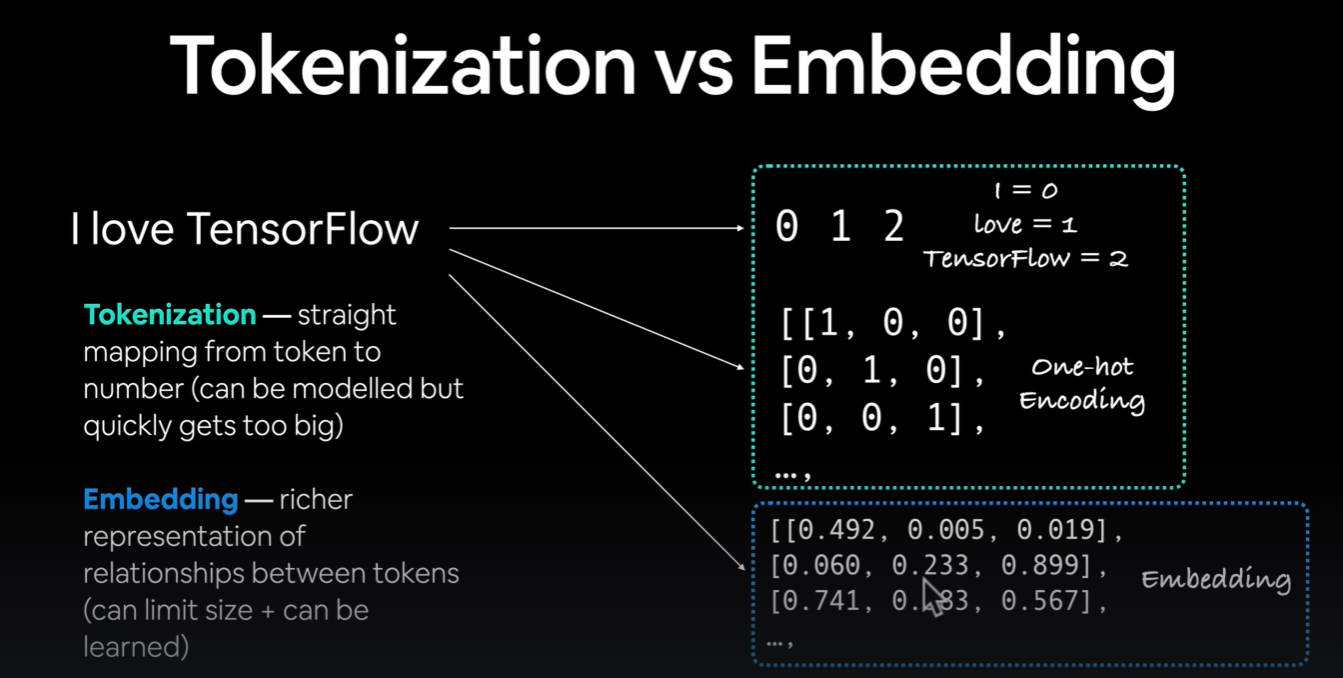

###4.1Tokenization

In [15]:
#Find the average number of tokens
round(sum([len(i.split()) for i in train_text])/len(train_text))

15

In [16]:
#Create a vectorization layer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
#Setup text vectorization variables
max_vocal_length=10000
max_length=15
text_vectorizer = TextVectorization(max_tokens=max_vocal_length, #how many words in the vocabulary
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, #create groups of n-words
                                    output_mode="int",
                                    output_sequence_length=max_length,
                                    pad_to_max_tokens=True)

In [17]:
#Fit the text vectorizer to the training text
text_vectorizer.adapt(train_text)

In [18]:
#Create a sample and tokenize it
sample_text="There's flood in my street!"
text_vectorizer([sample_text])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [19]:
#Choose a random sample from train dataset
random_text = random.choice(train_text)
print(f"Original text: {random_text}\n Vectorized version: ")
text_vectorizer([random_text])

Original text: 'It looks like a mudslide' 'It's like chewing on rubber' #GBBO ??????
 Vectorized version: 


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  15,  287,   25,    3,  456,   37,   25, 4014,   11, 1772,  896,
           0,    0,    0,    0]])>

In [20]:
#Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words=words_in_vocab[:5]
bottom_5_words=words_in_vocab[-5:]
print(f"Number of words in vocabulary: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocabulary: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


###4.2Embedding

The parameters we care the most about for our embedding layer:
* `input_dim` - the size of our vocabulary
* `output_dim` - the size of the output embedding vector, for example a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` - the length of the sequence beign passed to the embedding layer

In [21]:
#Create embedding layer
from tensorflow.keras.layers import Embedding
embedding = layers.Embedding(input_dim=max_vocal_length,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_length)

In [22]:
random_text = random.choice(train_text)
print(f"Original text: {random_text}\n Embedded version: ")
sample_embed = embedding(text_vectorizer([random_text]))
print(sample_embed)

Original text: Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.
 Embedded version: 
tf.Tensor(
[[[-0.04085971  0.01712729 -0.0028779  ... -0.01583629  0.00430263
   -0.01368611]
  [ 0.00090881  0.00037153  0.00156512 ... -0.02228259  0.04964249
   -0.03377332]
  [ 0.03992081  0.03540536 -0.04678493 ...  0.0425978  -0.02273766
   -0.0392995 ]
  ...
  [ 0.04748032 -0.00211488  0.00559428 ...  0.00166565 -0.03343435
    0.04238475]
  [-0.03245986 -0.03932265  0.03663596 ...  0.0418633  -0.00679358
    0.04790537]
  [-0.04544823 -0.02838765  0.01207949 ...  0.04535988  0.02933398
    0.03467547]]], shape=(1, 15, 128), dtype=float32)


In [23]:
sample_embed[0][0], sample_embed[0][0].shape, random_text[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.04085971,  0.01712729, -0.0028779 , -0.04465193,  0.0090823 ,
         0.01272876,  0.02535713, -0.04230097, -0.04312989,  0.02193714,
         0.0221689 , -0.03394312,  0.00064999,  0.02929466, -0.00578667,
        -0.00093824, -0.0411708 ,  0.03814328,  0.03060478,  0.01687239,
        -0.00840049,  0.0260298 ,  0.02428199,  0.0442613 , -0.04050871,
        -0.02089938, -0.03966565,  0.01616139, -0.03517244, -0.02408502,
         0.04802075, -0.04004773, -0.04094678,  0.03201872, -0.04393589,
         0.02099041, -0.00734726,  0.0015311 ,  0.00468638, -0.02075743,
        -0.04083493,  0.00353228,  0.03846167, -0.03507905, -0.02592464,
        -0.01361343, -0.00518131,  0.00183199,  0.02986677,  0.01113851,
         0.00481175,  0.04203763, -0.02592799,  0.01527072,  0.01524729,
         0.02266998, -0.02325345,  0.04216101,  0.04343608, -0.01733417,
        -0.01974884,  0.04552832,  0.03421792,  0.00303408, -0.04873991,
  

##5.Build the model

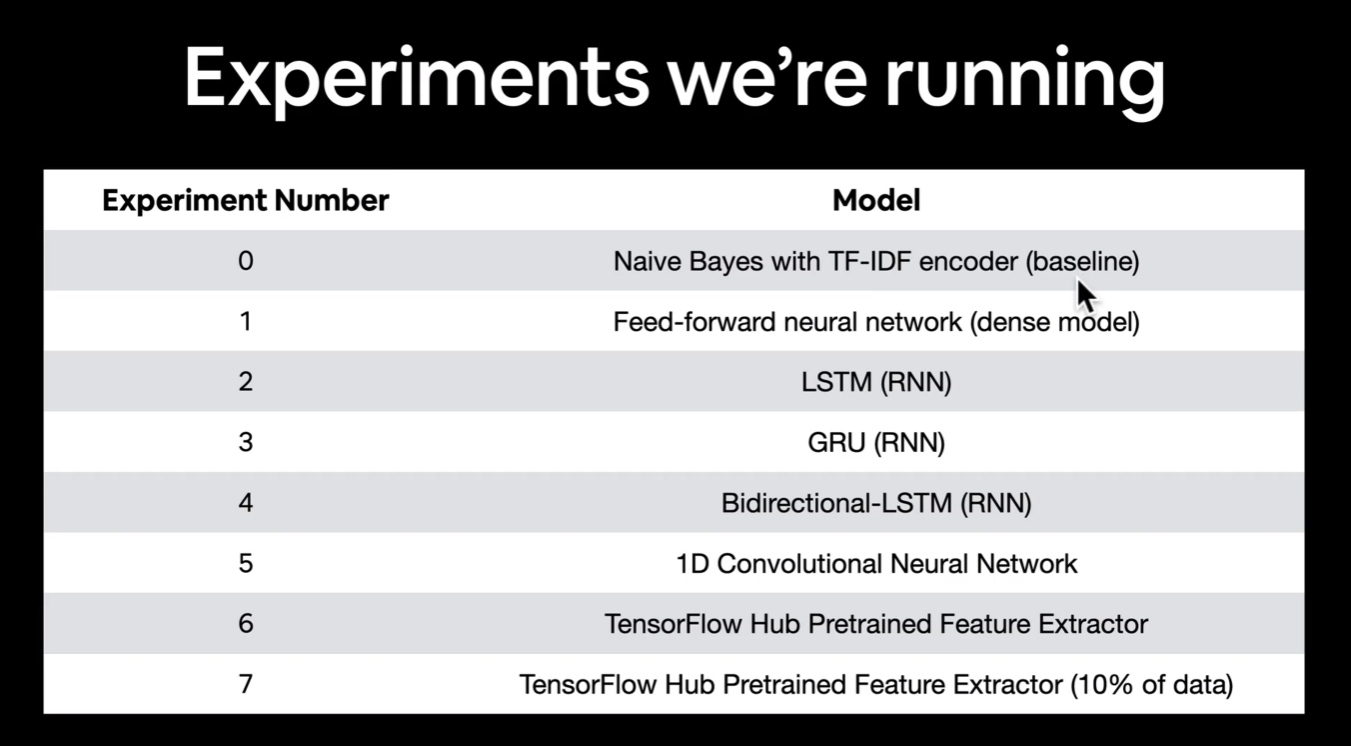

###Build the baseline model - Naive Bayes

We will use Sklearn's Multinomial Naive Bayes using TF-IDF formula to convert our words to numbers.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create tokenization and modelling pipeline
model_0 = Pipeline([("tfidf", TfidfVectorizer()), #convert words to numbers using tfidf
                    ("clf", MultinomialNB()) #model the text
                    ])
#Fit the pipeline to training data
model_0.fit(train_text, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
#Evaluate the baseline model
baseline_score = model_0.score(val_text, val_labels)
print(f"Baseline model accuracy: {baseline_score*100:.2f}")

Baseline model accuracy: 79.27


In [26]:
baseline_preds=model_0.predict(val_text)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

In [27]:
baseline_preds.shape

(762,)

###Create a function to evaluate our models

In [28]:
def f1_score_function(y_true, y_pred, class_names):
  from sklearn.metrics import classification_report
  print(classification_report(val_labels, baseline_preds))

  #Visualize the classification report
  classification_report_dict=classification_report(y_true, y_pred, output_dict=True)

  #Create empty dictionary
  class_f1_scores={}
  #Loop through classification report dictionary items
  for k,v in classification_report_dict.items():
      if k=="accuracy":
          break
      else:
          #Add class names and f1-scores to out dictionary
          class_f1_scores[class_names[int(k)]] = v["f1-score"]
  print(class_f1_scores)

  #Turn f1-scores into dataframe
  import pandas as pd
  f1_scores= pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                         "f1_score": list(class_f1_scores.values())}).sort_values("f1_score", ascending=False)

  return f1_scores

In [29]:
class_names=[0,1]

In [30]:
f1_score_function(val_labels, baseline_preds, class_names)

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       414
           1       0.89      0.63      0.73       348

    accuracy                           0.79       762
   macro avg       0.82      0.78      0.78       762
weighted avg       0.81      0.79      0.79       762

{0: 0.8301075268817204, 1: 0.734006734006734}


,class_names,f1_score
0,0,0.830108
1,1,0.734007


Read: https://scikit-learn.org/stable/modules/model_evaluation.html

In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1-score of a binary-classificattion model.
  """
  #Calculate accuracy
  model_accuracy=accuracy_score(y_true, y_pred)*100
  #Calculate model precision, recall and f1-score using weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

  model_results={"accuracy": model_accuracy,
                 "precision": model_precision,
                 "recall": model_recall,
                 "f1": model_f1}
  return model_results

In [32]:
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

###Build the Feed-Forward Neural Network model

In [33]:
from helper_functions import create_tensorboard_callback

In [34]:
#Build model using functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) #inputs a 1-dimensional string
x=text_vectorizer(inputs) #turn the input text into numbers
x=embedding(x) #create an embedding of numberized inputs
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(1, activation="sigmoid")(x)
model_1=tf.keras.Model(inputs, outputs, name="model_1_dense")

In [35]:
#Compile the model
model_1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [36]:
#Fit the model
history_1 = model_1.fit(x=train_text,
                        y=train_labels,
                        epochs=5,
                        validation_data=(val_text, val_labels),
                        callbacks=[create_tensorboard_callback("experiment_logs", "Feed_Forward_Model")])

Saving TensorBoard log files to: experiment_logs/Feed_Forward_Model/20231231-053142
Epoch 1/5
215/215 [==============================] - 9s 28ms/step - loss: 0.6110 - accuracy: 0.6930 - val_loss: 0.5373 - val_accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 6s 26ms/step - loss: 0.4416 - accuracy: 0.8184 - val_loss: 0.4710 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 0.3480 - accuracy: 0.8605 - val_loss: 0.4578 - val_accuracy: 0.7953
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2849 - accuracy: 0.8905 - val_loss: 0.4690 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2388 - accuracy: 0.9104 - val_loss: 0.4788 - val_accuracy: 0.7835


In [37]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [38]:
model_1_preds=model_1.predict(val_text)
model_1_preds.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [39]:
#Convert model prediction probabilities to label format
model_1_preds=tf.squeeze(tf.round(model_1_preds))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [40]:
#Evaluate the fast-forward model
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 78.34645669291339,
 'precision': 0.7880043492637875,
 'recall': 0.7834645669291339,
 'f1': 0.7804929895574078}

In [41]:
#Compare results of two models
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

###Visualize word embeddings with Tensorflow projector tool

In [42]:
#Get the vocabilary from the text vectorizer layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab)

10000

In [43]:
#Get the weight metrics of embedding layer
#These are the numerical representations of each token in out training data which have been learned for 5 epochs
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


We will be using Tensorflow projector to visualize embedding weights - https://projector.tensorflow.org/

Read:
* https://www.tensorflow.org/text/guide/word_embeddings
* https://www.tensorflow.org/text/tutorials/word2vec
* https://jalammar.github.io/illustrated-word2vec/


In [44]:
#Create embedding files
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [45]:
#Download files
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Build LSTM Recurrent Neural Network model

RNNs are useful for sequence data. The premise of a recurrent neural network is to use the representation of a previous input to aid the represenation of a later input.

RNN structure
`input (text)` -> `Tokenize` -> `Embedding` -> `Layers (RNNs/Dense)` -> `Output (label probability)`

* LSTM - Long Short Term Memory

Read:
* https://introtodeeplearning.com/
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://karpathy.github.io/2015/05/21/rnn-effectiveness/

In [46]:
#Create the model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) #when you are stacking RNN cells together you need to return sequences
print(x.shape)
x=layers.LSTM(64)(x)
print(x.shape)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 15, 64)
(None, 64)


In [47]:
#Compile the model
model_2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [48]:
#Fit the model
history_2 = model_2.fit(train_text,
                        train_labels,
                        epochs=5,
                        validation_data=(val_text, val_labels),
                        callbacks=[create_tensorboard_callback("experiment_logs", "model_2_rnn")])


Saving TensorBoard log files to: experiment_logs/model_2_rnn/20231231-053211
Epoch 1/5
215/215 [==============================] - 13s 37ms/step - loss: 0.2238 - accuracy: 0.9210 - val_loss: 0.5753 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 8s 38ms/step - loss: 0.1617 - accuracy: 0.9412 - val_loss: 0.6347 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 8s 38ms/step - loss: 0.1286 - accuracy: 0.9520 - val_loss: 0.7306 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 7s 33ms/step - loss: 0.1037 - accuracy: 0.9591 - val_loss: 0.7708 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0847 - accuracy: 0.9647 - val_loss: 1.0174 - val_accuracy: 0.7769


In [49]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                      

In [50]:
#Make predictions
model_2_preds=model_2.predict(val_text)
model_2_preds=tf.squeeze(tf.round(model_2_preds))

24/24 [==============================] - 1s 6ms/step


In [51]:
#Evaluate the model
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 77.69028871391076,
 'precision': 0.7822241302284023,
 'recall': 0.7769028871391076,
 'f1': 0.7734519762210931}

In [52]:
#Compare to baseline model
np.array(list(model_2_results)) > np.array(list(baseline_results))

array([False, False, False, False])

###Build GRU Recurrent Neural Network model

Read: https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

In [53]:
#Create the model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.GRU(64, return_sequences=True)(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)
# print(x.shape)
x = layers.GRU(64)(x)
# print(x.shape)
x = layers.Dense(64, activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

(None, 15, 128)
(None, 15, 64)


In [54]:
#Compile the model
model_3.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [55]:
#Fit the model
history_3 = model_3.fit(train_text,
                        train_labels,
                        epochs=5,
                        validation_data=(val_text, val_labels),
                        callbacks=[create_tensorboard_callback("experiment_logs","model_3_gru")])

Saving TensorBoard log files to: experiment_logs/model_3_gru/20231231-053258
Epoch 1/5
215/215 [==============================] - 13s 43ms/step - loss: 0.1564 - accuracy: 0.9441 - val_loss: 0.8412 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 7s 35ms/step - loss: 0.0837 - accuracy: 0.9682 - val_loss: 0.8170 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0670 - accuracy: 0.9711 - val_loss: 1.0998 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 9s 40ms/step - loss: 0.0594 - accuracy: 0.9755 - val_loss: 1.1405 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0536 - accuracy: 0.9769 - val_loss: 1.5492 - val_accuracy: 0.7690


In [56]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                       

In [57]:
#Make predictions
model_3_preds=model_3.predict(val_text)
model_3_preds=tf.squeeze(tf.round(model_3_preds))

24/24 [==============================] - 1s 5ms/step


In [58]:
#Evaluate the model
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 76.9028871391076,
 'precision': 0.769557843731072,
 'recall': 0.7690288713910761,
 'f1': 0.7675415573053368}

In [59]:
#Compare to baseline
np.array(list(model_3_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

###Building Bidirectional Recurrent Neural Network model

Normal RNNs go from left to right. Bidirectional RNN go from left to right as well as right to left.

Read: https://www.tensorflow.org/guide/keras/working_with_rnns

In [60]:
 #Create the model
 inputs = layers.Input(shape=(1,), dtype="string")
 x = text_vectorizer(inputs)
 x = embedding(x)
 x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
 x = layers.Bidirectional(layers.GRU(64))(x)
 outputs = layers.Dense(1, activation="sigmoid")(x)
 model_4 = tf.keras.Model(inputs,outputs)

In [61]:
#Compile the model
model_4.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics =["accuracy"]
)

In [62]:
#Fit the model
history_4 = model_4.fit(train_text,
                        train_labels,
                        epochs=5,
                        validation_data=(val_text, val_labels),
                        callbacks = [create_tensorboard_callback("experiment_logs","model_4")])

Saving TensorBoard log files to: experiment_logs/model_4/20231231-053346
Epoch 1/5
215/215 [==============================] - 21s 62ms/step - loss: 0.1016 - accuracy: 0.9654 - val_loss: 1.2898 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 13s 62ms/step - loss: 0.0526 - accuracy: 0.9759 - val_loss: 1.1792 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 12s 54ms/step - loss: 0.0471 - accuracy: 0.9761 - val_loss: 1.7072 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 12s 54ms/step - loss: 0.0457 - accuracy: 0.9781 - val_loss: 1.2065 - val_accuracy: 0.7546
Epoch 5/5
215/215 [==============================] - 10s 47ms/step - loss: 0.0421 - accuracy: 0.9785 - val_loss: 1.4861 - val_accuracy: 0.7559


In [63]:
#Make predictions
model_4_preds=model_4.predict(val_text)
model_4_preds=tf.squeeze(tf.round(model_4_preds))

24/24 [==============================] - 2s 10ms/step


In [64]:
#Evaluate the model
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 75.59055118110236,
 'precision': 0.7554675034359861,
 'recall': 0.7559055118110236,
 'f1': 0.7554294322581303}

In [65]:
#Compare to baseline model
np.array(list(model_4_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [66]:
model_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 15, 128)           98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                             

###Build 1D Convolutional Neural Network model

In [67]:
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))

conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding="same")
conv1d_output=conv_1d(embedding_test)
max_pool=layers.GlobalMaxPool1D()
max_pool_output=max_pool(conv1d_output)
embedding_test.shape, conv1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [68]:
#Create the model
inputs=layers.Input(shape=(1,), dtype="string")
x=text_vectorizer(inputs)
x=embedding(x)
print(x.shape)
x=layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="same", activation="relu")(x)
print(x.shape)
x=layers.GlobalMaxPool1D()(x)
print(x.shape)
# x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(1, activation="sigmoid")(x)
print(outputs.shape)
model_5=tf.keras.Model(inputs, outputs, name="model_5_conv1d")

(None, 15, 128)
(None, 15, 64)
(None, 64)
(None, 1)


In [69]:
#Compile the model
model_5.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [70]:
#Fit the model
history_5 = model_5.fit(train_text,
                        train_labels,
                        epochs=5,
                        validation_data=(val_text, val_labels),
                        callbacks=[create_tensorboard_callback("experiment_log","model_5_conv1d")])

Saving TensorBoard log files to: experiment_log/model_5_conv1d/20231231-053517
Epoch 1/5
215/215 [==============================] - 6s 23ms/step - loss: 0.1208 - accuracy: 0.9642 - val_loss: 0.8789 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0706 - accuracy: 0.9726 - val_loss: 0.9992 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0585 - accuracy: 0.9768 - val_loss: 1.1155 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0527 - accuracy: 0.9775 - val_loss: 1.1497 - val_accuracy: 0.7507
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0494 - accuracy: 0.9790 - val_loss: 1.2032 - val_accuracy: 0.7625


In [71]:
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 1)              

In [72]:
#Make predictions
model_5_preds=model_5.predict(val_text)
model_5_preds=tf.squeeze(tf.round(model_5_preds))

24/24 [==============================] - 0s 3ms/step


In [73]:
#Evaluate the model
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 76.24671916010499,
 'precision': 0.7651076306104088,
 'recall': 0.7624671916010499,
 'f1': 0.7596743073939078}

In [74]:
#Compare to baseline
np.array(list(model_5_results.values()))>np.array(list(baseline_results.values()))

array([False, False, False, False])

###Use pretrained model from Tensorflow Hub

In [75]:
import tensorflow_hub as hub
model_url = "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2"
USE_embed = hub.load(model_url)
sample_embeddings = USE_embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(sample_embeddings)

tf.Tensor(
[[-0.03133017 -0.06338634 -0.01607501 ... -0.03242778 -0.0457574
   0.05370456]
 [ 0.0508086  -0.01652434  0.01573779 ...  0.00976657  0.03170121
   0.01788118]], shape=(2, 512), dtype=float32)


In [76]:
embed_layer_encoder = hub.KerasLayer(model_url,
                                     input_shape=[],
                                     dtype=tf.string,
                                     name="USE")

model_6 = tf.keras.Sequential([
    embed_layer_encoder,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model_6.compile(
    loss="binary_crossentropy",
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adam()
)
model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [77]:
#Fit the model
history_6=model_6.fit(train_text,
                      train_labels,
                      epochs=5,
                      validation_data=(val_text,val_labels),
                      callbacks=[create_tensorboard_callback("experiment_log","model_6")])

Saving TensorBoard log files to: experiment_log/model_6/20231231-053607
Epoch 1/5
215/215 [==============================] - 7s 18ms/step - loss: 0.5062 - accuracy: 0.7834 - val_loss: 0.4513 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4138 - accuracy: 0.8183 - val_loss: 0.4376 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4000 - accuracy: 0.8234 - val_loss: 0.4329 - val_accuracy: 0.8150
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3924 - accuracy: 0.8270 - val_loss: 0.4285 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3849 - accuracy: 0.8301 - val_loss: 0.4328 - val_accuracy: 0.8136


In [78]:
#Make predictions
model_6_preds=model_6.predict(val_text)
model_6_preds=tf.squeeze(tf.round(model_6_preds))

24/24 [==============================] - 1s 7ms/step


In [79]:
#Evaluate the model
model_6_results=calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.36482939632546,
 'precision': 0.8174785156553263,
 'recall': 0.8136482939632546,
 'f1': 0.8116306237412022}

In [80]:
#Compare to baseline
np.array(list(model_6_results.values())) > np.array(list(baseline_results.values()))

array([ True,  True,  True,  True])

###Use 10 percent of training data

In [81]:
train_10_percent = train_data_shuffled[["text","target"]].sample(frac=0.1, random_state=42)
# train_text_10_precent=train_10_percent["text"]
# train_labels_10_percent=train_10_percent["target"]

In [89]:
#Split data into training and validation datasets
from sklearn.model_selection import train_test_split

train_text_10_percent, val_text_10_percent, train_labels_10_percent, val_labels_10_percent = train_test_split(train_10_percent["text"].to_numpy(),
                                                                  train_10_percent["target"].to_numpy(),
                                                                  test_size=0.1, #use 10% of training data for validation
                                                                  random_state=42)

In [92]:
len(train_text_10_percent), len(train_labels_10_percent), len(val_text_10_percent), len(val_labels_10_percent)

(684, 684, 77, 77)

In [91]:
train_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

To recreate the same model as we created before we can use tf.keras.models.clone_model() method.

In [93]:
#Clone the model
model_7 = tf.keras.models.clone_model(model_6)

In [94]:
#Compile the model
model_7.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [95]:
#Fit the model
history_7 = model_7.fit(train_text_10_percent,
                        train_labels_10_percent,
                        epochs=5,
                        validation_data=(val_text_10_percent, val_labels_10_percent),
                        callbacks=[create_tensorboard_callback("experiment_logs","model_7")])

Saving TensorBoard log files to: experiment_logs/model_7/20231231-053747
Epoch 1/5
22/22 [==============================] - 4s 34ms/step - loss: 0.6735 - accuracy: 0.6681 - val_loss: 0.6425 - val_accuracy: 0.7532
Epoch 2/5
22/22 [==============================] - 0s 10ms/step - loss: 0.6139 - accuracy: 0.7836 - val_loss: 0.5775 - val_accuracy: 0.7532
Epoch 3/5
22/22 [==============================] - 0s 12ms/step - loss: 0.5431 - accuracy: 0.7924 - val_loss: 0.5241 - val_accuracy: 0.7532
Epoch 4/5
22/22 [==============================] - 0s 11ms/step - loss: 0.4848 - accuracy: 0.8026 - val_loss: 0.4813 - val_accuracy: 0.7532
Epoch 5/5
22/22 [==============================] - 0s 12ms/step - loss: 0.4424 - accuracy: 0.8085 - val_loss: 0.4643 - val_accuracy: 0.7922


In [96]:
#Make predictions
model_7_preds=model_7.predict(val_text)
model_7_preds = tf.squeeze(tf.round(model_7_preds))

24/24 [==============================] - 1s 7ms/step


In [97]:
#Evaluate the model
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 81.49606299212599,
 'precision': 0.8149204136886106,
 'recall': 0.8149606299212598,
 'f1': 0.8149391120349354}

In [98]:
#Compare to model_6
np.array(list(model_7_results.values())) > np.array(list(model_6_results.values()))

array([ True, False,  True,  True])

###Compare results of all models

In [99]:
all_models_results = pd.DataFrame({"baseline": baseline_results,
                                   "model_1": model_1_results,
                                   "model_2": model_2_results,
                                   "model_3": model_3_results,
                                   "model_4": model_4_results,
                                   "model_5": model_5_results,
                                   "model_6": model_6_results,
                                   "model_7": model_7_results})

In [100]:
all_models_results=all_models_results.transpose()
all_models_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
model_1,78.346457,0.788004,0.783465,0.780493
model_2,77.690289,0.782224,0.776903,0.773452
model_3,76.902887,0.769558,0.769029,0.767542
model_4,75.590551,0.755468,0.755906,0.755429
model_5,76.246719,0.765108,0.762467,0.759674
model_6,81.364829,0.817479,0.813648,0.811631
model_7,81.496063,0.814920,0.814961,0.814939


In [101]:
all_models_results["accuracy"]=all_models_results["accuracy"]/100

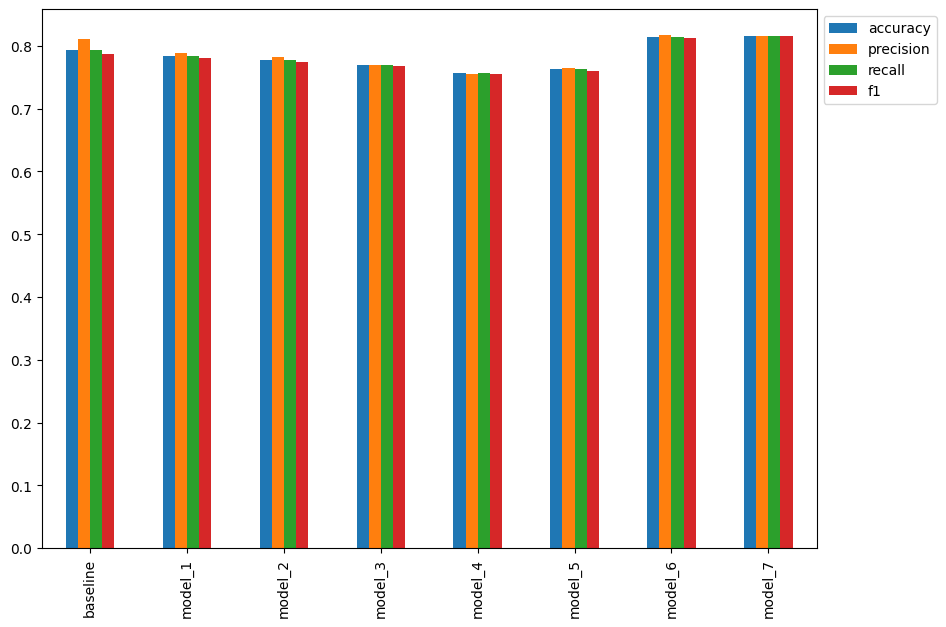

In [102]:
#Plot and compare all of the models results
all_models_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

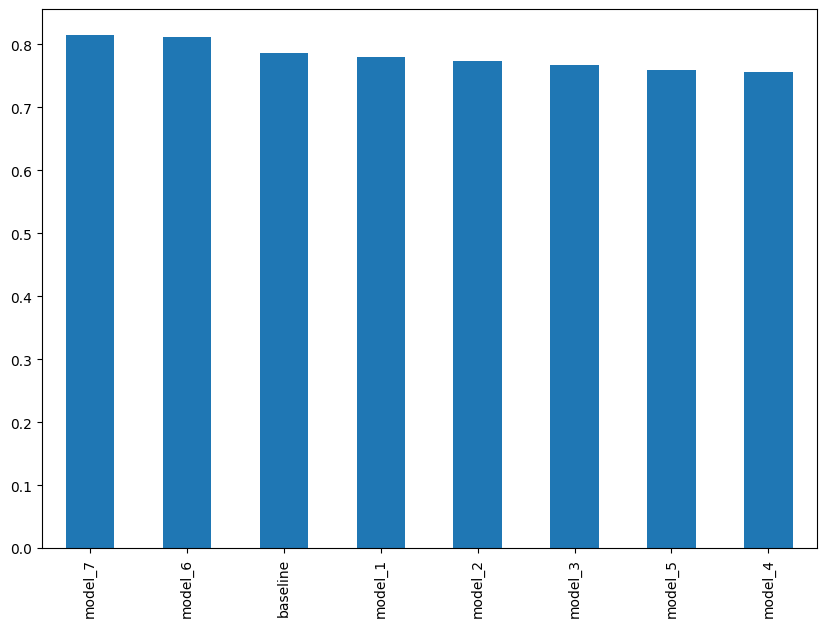

In [103]:
all_models_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

In [104]:
model_7.save("Best_NLP_Model")

In [105]:
model_7.save("Best_NLP_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [106]:
loaded_model_1 = tf.keras.models.load_model("Best_NLP_Model")

In [107]:
loaded_model_h5 = tf.keras.models.load_model("Best_NLP_Model.h5", custom_objects={"KerasLayer":hub.KerasLayer})

In [108]:
loaded_model_1.evaluate(val_text, val_labels)

24/24 [==============================] - 1s 8ms/step - loss: 0.4259 - accuracy: 0.8150


[0.4259146451950073, 0.8149606585502625]

In [109]:
loaded_model_h5.evaluate(val_text, val_labels)

24/24 [==============================] - 1s 8ms/step - loss: 0.4259 - accuracy: 0.8150


[0.4259146451950073, 0.8149606585502625]

###Finding the most wrong examples

In [110]:
#Create dataframe with validation sentences and best performing model
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
unzip_file("08_model_6_USE_feature_extractor.zip")

--2023-12-31 06:00:28--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.207, 142.251.179.207, 142.251.16.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  63.1MB/s    in 16s     

2023-12-31 06:00:45 (55.8 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]



In [111]:
#Import model
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")

In [112]:
#Evaluate the model
model_6_pretrained.evaluate(val_text, val_labels)

24/24 [==============================] - 1s 19ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [115]:
#Make predictions
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_text)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 0s 7ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [117]:
val_df = pd.DataFrame({"text": val_text,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "probs": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [122]:
#Sort by prediction probability where target is not equal to prediction
most_wrong = val_df[val_df["target"]!=val_df["pred"]].sort_values("probs", ascending=False)
#False positives
most_wrong.head(10)

,text,target,pred,probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [123]:
#False negatives
most_wrong.tail(10)

,text,target,pred,probs
536,@DavidVonderhaar At least you were sincere ??,1,0.0,0.067303
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.055076
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.054603
221,going to redo my nails and watch behind the sc...,1,0.0,0.054597
59,You can never escape me. Bullets don't harm me...,1,0.0,0.049637
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [125]:
#Check the false positives
for row in most_wrong[:10].itertuples():
  _,text, target, pred, probs = row
  print(f"Target: {target}, Pred: {pred}, Prob: {probs}")
  print(f"Text: {text}")

Target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text: ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying
Target: 0, Pred: 1.0, Prob: 0.8769820332527161
Text: FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J
Target: 0, Pred: 1.0, Prob: 0.8523001670837402
Text: @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.
Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text: Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
Target: 0, Pred: 1.0, Prob: 0.8272131681442261
Text: @AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.
Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text: @SonofLiberty357 all illuminated by the brightly burning buildings all around the town!
Target: 0, Pred: 1.0, Prob: 0.8108397126

In [126]:
#Check the false negatives
for row in most_wrong[-10:].itertuples():
  _,text, target, pred, probs = row
  print(f"Target: {target}, Pred: {pred}, Prob: {probs}")
  print(f"Text: {text}")

Target: 1, Pred: 0.0, Prob: 0.06730345636606216
Text: @DavidVonderhaar At least you were sincere ??
Target: 1, Pred: 0.0, Prob: 0.055075839161872864
Text: @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu
Target: 1, Pred: 0.0, Prob: 0.054603397846221924
Text: Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets
Target: 1, Pred: 0.0, Prob: 0.05459701269865036
Text: going to redo my nails and watch behind the scenes of desolation of smaug ayyy
Target: 1, Pred: 0.0, Prob: 0.04963730648159981
Text: You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.
Target: 1, Pred: 0.0, Prob: 0.04391849413514137
Text: @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren
Target: 1, Pred: 0.0, Prob: 0.042086850851774216
Text: I get to smoke my

In [129]:
#Make predictions on test dataset
model_6_pretrained_test_pred_probs = model_6_pretrained.predict(test_data["text"].to_list())
model_6_pretrained_test_preds = tf.squeeze(tf.round(model_6_pretrained_test_pred_probs))
model_6_pretrained_test_preds[:10]

102/102 [==============================] - 1s 9ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [133]:
test_text = test_data["text"].to_list()
test_samples = random.sample(test_text, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  print(f"Prediction: {pred_prob}")
  print(f"Test text: {test_sample}")
  print("-----")

1/1 [==============================] - 0s 42ms/step
Prediction: 0.10210180282592773
Test text: The goddess is said to be married to either Perk?nas (thunder god) or Praam_ius (manifestation of chief heavenly god Dievas).
-----
1/1 [==============================] - 0s 36ms/step
Prediction: 0.5718100070953369
Test text: Disaster [Chapter 27] https://t.co/EAsxT3y84R http://t.co/CjUFunsDKg
-----
1/1 [==============================] - 0s 34ms/step
Prediction: 0.9084581136703491
Test text: Hailstorm cleanup begins in Calgary http://t.co/DhH5jz2w49
-----
1/1 [==============================] - 0s 39ms/step
Prediction: 0.20991596579551697
Test text: I hope I get electrocuted today at work
-----
1/1 [==============================] - 0s 36ms/step
Prediction: 0.9649145603179932
Test text: '1 Death is a tragedy; a million Deaths is a statistic.' Stalin August 6 1945 U.S. Atomic Bomb Dropped On... http://t.co/kaMPx4eOS9
-----
1/1 [==============================] - 0s 36ms/step
Prediction: 0.16422

##The Speed/Score Tradeoff

In [134]:
#Make a function to measure the time of prediction
import time
def pred_time(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time =time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_prediction = total_time/len(samples)
  return total_time, time_per_prediction

In [135]:
model_6_pred_time, model_6_time_per_pred = pred_time(model_6, val_text)
model_6_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 8ms/step


(0.3706090979999317, 0.0004863636456692017)

In [141]:
model_6_pretrained_results = calculate_results(val_labels, model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

In [138]:
baseline_pred_time, baseline_time_per_pred = pred_time(model_0, val_text)
baseline_pred_time, baseline_time_per_pred

(0.019739442000172858, 2.5904779527785903e-05)

Text(0, 0.5, 'F1-score')

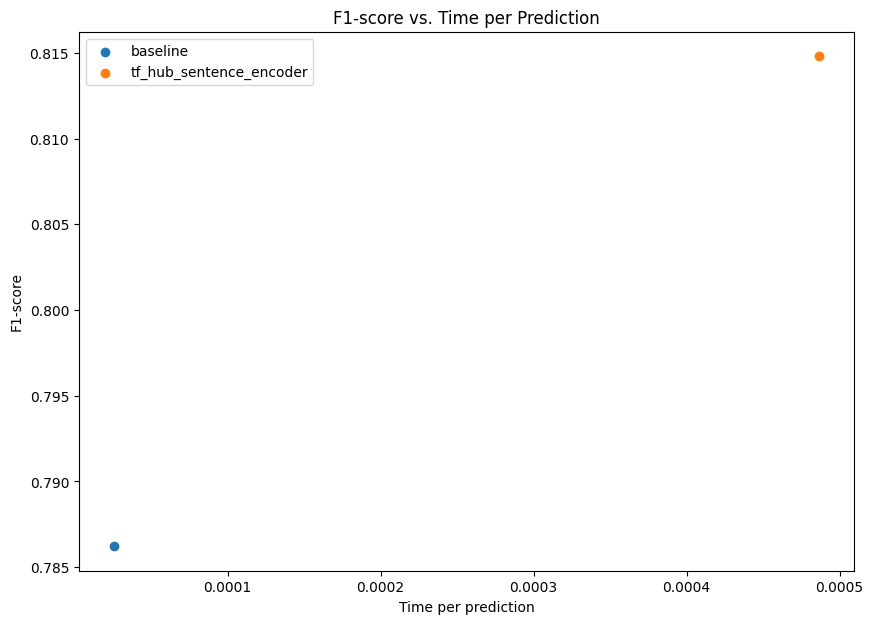

In [145]:
plt.figure(figsize=(10,7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.title("F1-score vs. Time per Prediction")
plt.legend()
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")